## BERT Fine-Tuning with PyTorch

BERT with the huggingface PyTorch library to fine-tune a model to get near state of the art performance in Tweet Disaster Classification.

- which layers are trained?
- loss function?
- for binary classfication, how ot deal with class imbalance
- Hyperparameter tunning

### 1. Setup 

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

SystemError: GPU device not found

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## 2. Loading data

In [13]:
import os
import re
import torch
import numpy as np
import pandas as pd

for dirname, _, filenames in os.walk('data_bert/tweet'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data_bert/tweet/test.csv
data_bert/tweet/train.csv
data_bert/tweet/sample_submission.csv


In [2]:
train_df = pd.read_csv('data_bert/tweet/train.csv', encoding='UTF-8')
print('Number of the samples', len(train_df))

train_df.head()

Number of the samples 7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# #HappyEmoticons
# emoticons_happy = set([
#     ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
#     ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
#     '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
#     'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
#     '<3'
#     ])

# # Sad Emoticons
# emoticons_sad = set([
#     ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
#     ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
#     ':c', ':{', '>:\\', ';('
#     ])

# #combine sad and happy emoticons
# emoticons = emoticons_happy.union(emoticons_sad)


#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [4]:
from nltk.tokenize import WordPunctTokenizer
import re
import emoji
from bs4 import BeautifulSoup
import itertools

tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'

def tweet_cleaner(text): # ref: https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
    # removing UTF-8 BOM (Byte Order Mark)
    try:
        text1 = text.decode("utf-8-sig").replace(u"\ufffd", "?") # The UTF-8 BOM is a sequence of bytes (EF BB BF) that allows the reader to identify a file as being encoded in UTF-8
    except:
        text1 = text
    
    
    #replace consecutive non-ASCII characters with a space
    text1 = re.sub(r'[^\x00-\x7F]+',' ', text1)
    
    #remove emojis from tweet
    text2 = emoji_pattern.sub(r'', text1)
    
    # Remove emoticons
    # text3 = [word for word in text2.split() if word not in emoticons]
    # text3 = " ".join(text3)
    
    # contradictions and special characters 
    # text4 = spl_ch_contra(text3)
    
    # HTML encoding
    soup = BeautifulSoup(text2, 'lxml') #HTML encoding has not been converted to text, and ended up in text field as ‘&amp’,’&quot’,etc.
    text5 = soup.get_text()
    
    # removing @ mentions
    text6 = re.sub(pat1, '', text5)
    
    # Removing URLs
    text7 = re.sub(pat2, '', text6)
    
    # Removing punctuations
    # text8 = re.sub("[\.\,\!\?\:\;\-\=\(\)\[\]\"\'\%\*\#\@]", " ", text7)
    
    # Fix misspelled words
    text9 = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text7))# checking that each character should occur not more than 2 times in every word

    # Tokenizing ,change cases & join together to remove unneccessary white spaces
    text9_list = tok.tokenize(text9.lower())
    text10 = (" ".join(text9_list)).strip()
    
    return text10

In [5]:
# cleaning out few samples
train_df['text_cleaned'] = list(map(lambda x: tweet_cleaner(x), train_df['text']))

/var/folders/vs/mzpg5tzx47xcyt0_pqpg7gv80000gn/T/ipykernel_18680/2894781763.py:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text2, 'lxml') #HTML encoding has not been converted to text, and ended up in text field as ‘&amp’,’&quot’,etc.


In [6]:
# Get a list of sentences and their labels

sentences = train_df.text_cleaned.values
labels = train_df.target.values

## 3. Tokenization & Input Formatting

In [7]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [11]:
print("Original sentence", sentences[0])
print("Tokenized: ", tokenizer.tokenize(sentences[0]))
# print("Tokenized: ", tokenizer(sentences[0]))
print("Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original sentence our deeds are the reason of this # earthquake may allah forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


### 3.2 Required Formatting

- add special tokens to the start and the end of a sentences
- Pad & Truncate the sentence into a constant length
- explicitly differentiate real tokens from padding tokens with the "attention mask"

####  [SEP]  [CLS] [PAD]

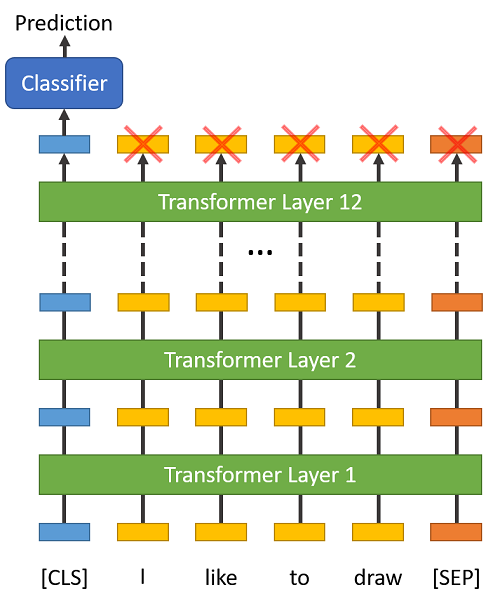

### **Bert Limitations**

Bert has two constraints:
- **All sentense must be padded or truncated to a single, fixed length**
- **the maximum sentence length is 512 tokens**

Padding is done with a special [PAD] token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT not to incorporate these PAD tokens into its interpretation of the sentence.

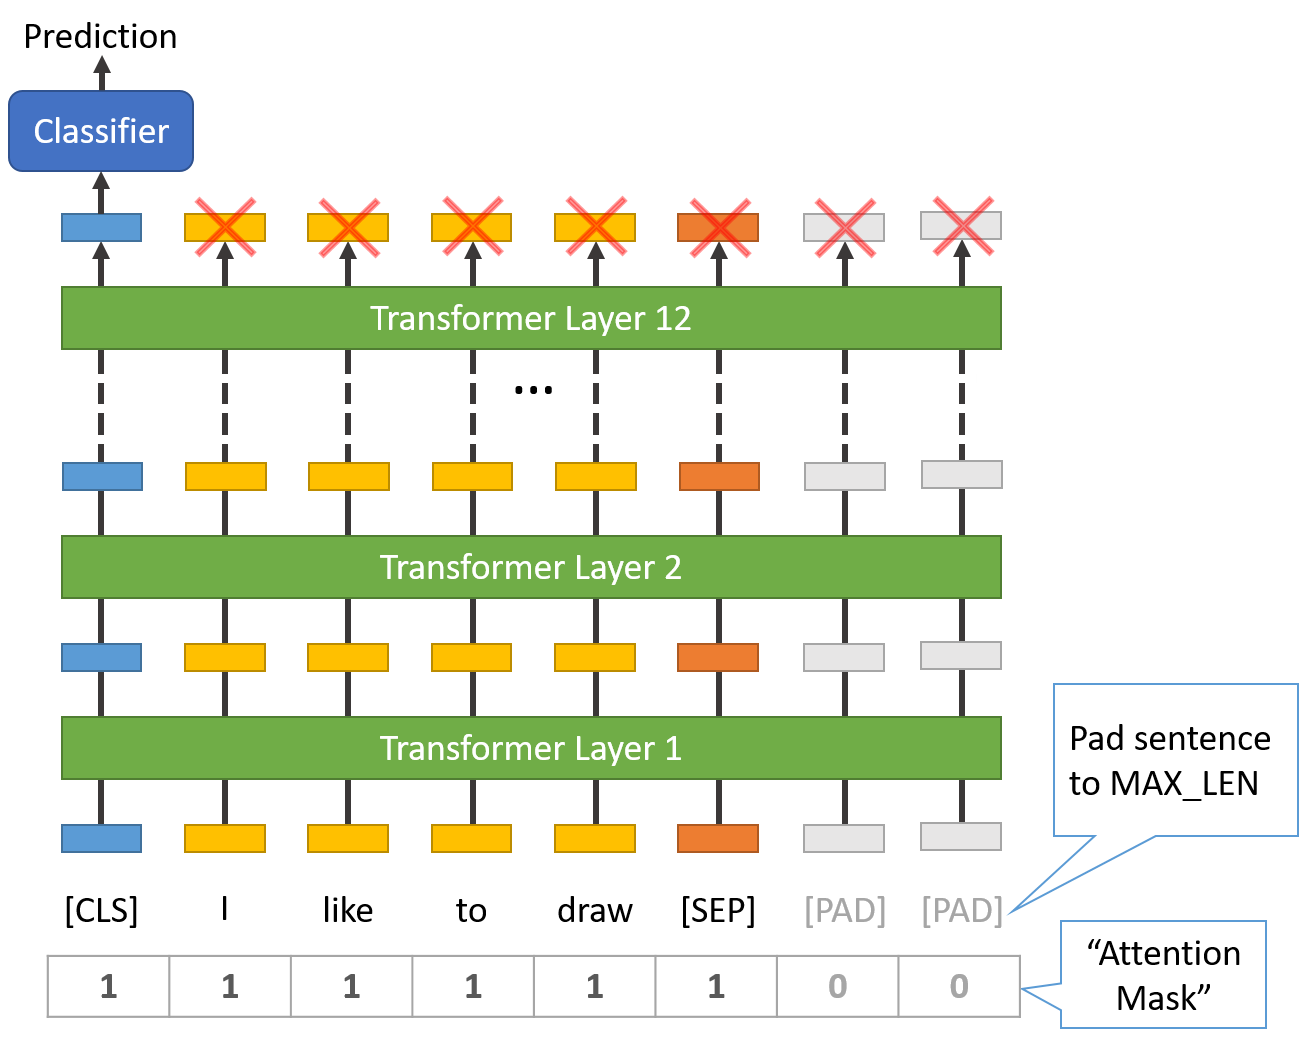

In [ ]:
#  find the maximum lengthz   
max_len = 0

for sent in sentences:
    input = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(len(input), max_len)
print("Maximum sentence length: ", max_len)

In [20]:
input_ids = []
attention_masks = []

for sent in sentences:
    # 'encode_plus will'
    # 1. tokenize the sentencs.
    # 2. prepend the '[CLS]' token to the start
    # 3. Append the '[SEP]' token to the end 
    # 4. Map token to their IDs
    # 5. Pad or truncate the sentencs to 'max_length'
    # 6. Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
        sent, # sentence to encode
        add_special_tokens = True, # add '[CLS]' and '[SEP]'
        max_length = 75, # Pad or truncate all sentences,
        pad_to_max_length = True, 
        return_attention_mask = True, # Construct attnetion masks
        return_tensors = 'pt', # return pytorch tensors
    )

    # add the encoded sentence to the list
    input_ids.append(encoded_dict['input_ids'])
    # and its 
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print("Original: ", sentences[1])
print("Token IDs: ", input_ids[1])


/Users/tianyuliu/Library/Caches/pypoetry/virtualenvs/nlp-examples-2S-piTS9-py3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  forest fire near la ronge sask . canada
Token IDs:  tensor([  101,  3224,  2543,  2379,  2474,  6902,  3351, 21871,  2243,  1012,
         2710,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])


#### Training & Validation Split

In [21]:
from torch.utils.data import TensorDataset, random_split

# combine the training inputs and labels into the dataset
dataset = TensorDataset(input_ids, attention_masks, labels)
# create the training-validation dataset
train_len = int( 0.9 * len(dataset)) 
valid_len = len(dataset) - train_len

train_dataset, val_dataset = random_split(dataset, [train_len, valid_len])



In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size=batch_size
)

## 4. Training the clasfication model

### BertForSequenceClassfication

- BertModel
- BertForPreTraining
- BertForMaskedLM
- BertForNextSentencePrediction
- BertForSequenceClassification - The one we'll use.
- BertForTokenClassification
- BertForQuestionAnswering

For the BertForSequenceClassfication model, this is the normal Bert model with an added linear layer on top for classficatgion. 

In [27]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False

)

# Tell pytorch to run this model on the GPU.
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### 4.2. Optimizer & Learning Rate Scheduler
- batch size 
- learning rate
- opoch

In [29]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
)

/Users/tianyuliu/Library/Caches/pypoetry/virtualenvs/nlp-examples-2S-piTS9-py3.12/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [36]:
from transformers import get_linear_schedule_with_warmup
epochs = 2
total_steps = epochs * len(train_dataloader)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps= 0,
    num_training_steps=total_steps
)


In [37]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [35]:
import time
import datetime

def format_time(elapsed):
    '''Takes a time in seconds and returns a string hh:mm:ss'''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [45]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 66

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0]   # .to(device)
        b_input_mask = batch[1]  #  .to(device)
        b_labels = batch[2]      # .to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # are given and what flags are set. For our usage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss, logits = outputs.loss, outputs.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        b_input_ids = batch[0]  # .to(device)
        b_input_mask = batch[1] # .to(device)
        b_labels = batch[2]     # .to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        loss, logits = outputs.loss, outputs.logits
        
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 2 ========
Training...
  Batch    40  of    215.    Elapsed: 0:03:04.
  Batch    80  of    215.    Elapsed: 0:05:18.
  Batch   120  of    215.    Elapsed: 0:07:31.
  Batch   160  of    215.    Elapsed: 0:09:44.
  Batch   200  of    215.    Elapsed: 0:12:00.

  Average training loss: 0.20
  Training epcoh took: 0:12:47

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.45
  Validation took: 0:00:14
======== Epoch 2 / 2 ========
Training...
  Batch    40  of    215.    Elapsed: 0:02:36.
  Batch    80  of    215.    Elapsed: 0:05:06.
  Batch   120  of    215.    Elapsed: 0:07:40.
  Batch   160  of    215.    Elapsed: 0:09:59.
  Batch   200  of    215.    Elapsed: 0:12:33.

  Average training loss: 0.21
  Training epcoh took: 0:13:28

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.45
  Validation took: 0:00:15

Training complete!
Total training took 0:26:44 (h:mm:ss)


In [ ]:
import pandas as pd

df_stats = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.201794,0.449454,0.847756,0:12:47,0:00:14
2,0.205453,0.449454,0.847756,0:13:28,0:00:15


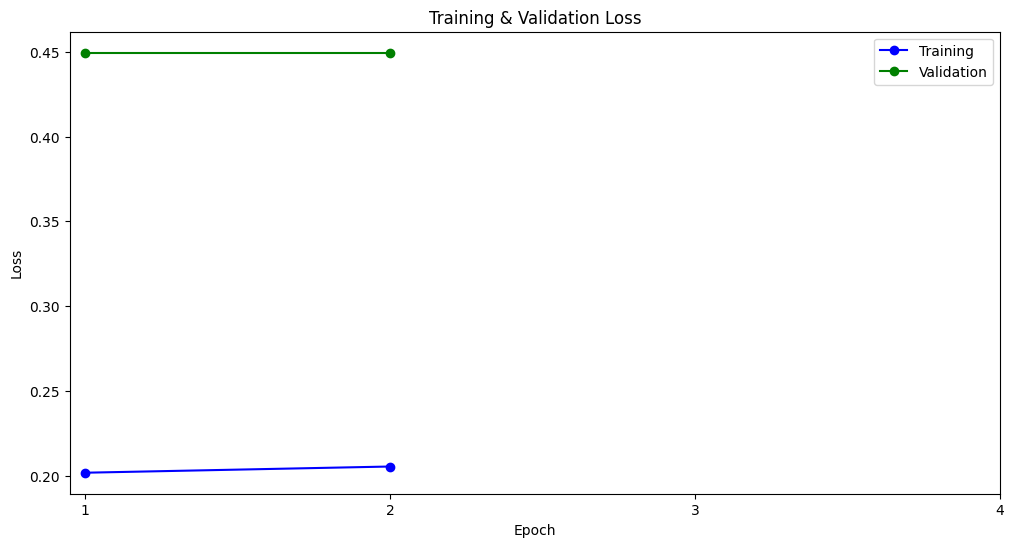

In [54]:
import matplotlib.pyplot as plt

# import seaborn as sns

# # Use plot styling from seaborn.
# sns.set(style='darkgrid')

# # Increase the plot size and font size.
# sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## 5 performance test

In [57]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv('data_bert/tweet/test.csv')

# preprocessing text
df['text_cleaned'] = list(map(lambda x: tweet_cleaner(x),df['text']))

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.text_cleaned.values
# labels = df.target.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 75,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
# prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/var/folders/vs/mzpg5tzx47xcyt0_pqpg7gv80000gn/T/ipykernel_18680/2894781763.py:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text2, 'lxml') #HTML encoding has not been converted to text, and ended up in text field as ‘&amp’,’&quot’,etc.
/Users/tianyuliu/Library/Caches/pypoetry/virtualenvs/nlp-examples-2S-piTS9-py3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Number of test sentences: 3,263



In [59]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t for t in batch)
  # batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  # b_input_ids, b_input_mask, b_labels = batch
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  # label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  # true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,263 test sentences...
    DONE.


In [ ]:
# # Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# # For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# adding to the main datframe
df['target'] = flat_predictions

# # Combine the correct labels for each batch into a single list.
# flat_true_labels = np.concatenate(true_labels, axis=0)

# # Calculate the MCC
# mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

# print('Total MCC: %.3f' % mcc)

ValueError: need at least one array to concatenate

## Appendix save model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './tweet_classification_model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))
